In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

from tensorflow.keras.applications import MobileNetV2,Xception,EfficientNetB7,InceptionResNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Input,LSTM, ConvLSTM2D, MaxPooling3D, TimeDistributed, Dense, Flatten, Dropout, Bidirectional, MaxPooling2D, InputLayer, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, Model, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, Callback

from IPython.display import clear_output,Video

import os
import json
import cv2

#constants
IMG_SIZE = 128
FRAME_COUNT = 15

In [ ]:
!unzip "/content/Video surveillance (2).zip"

Archive:  /content/Video surveillance (2).zip
   creating: Video surveillance/
   creating: Video surveillance/SCVD/
   creating: Video surveillance/SCVD/SCVD_converted/
   creating: Video surveillance/SCVD/SCVD_converted/Test/
   creating: Video surveillance/SCVD/SCVD_converted/Test/Normal/
  inflating: Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n001_converted.avi  
  inflating: Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n002_converted.avi  
  inflating: Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n003_converted.avi  
  inflating: Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n004_converted.avi  
  inflating: Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n005_converted.avi  
  inflating: Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n006_converted.avi  
  inflating: Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n007_converted.avi  
  inflating: Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n008_converted.avi  
  inflating

In [ ]:
scvd_train_dir = '/content/Video surveillance/SCVD/SCVD_converted/Train'
scvd_test_dir = '/content/Video surveillance/SCVD/SCVD_converted/Test'
scvd_classes = ['Normal', 'Violence','Weaponized']

In [ ]:
!apt-get install -y ffmpeg

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
ffmpeg is already the newest version (7:4.4.2-0ubuntu0.22.04.1).
0 upgraded, 0 newly installed, 0 to remove and 29 not upgraded.


In [ ]:
!ffmpeg -loglevel error -i '/content/Video surveillance/SCVD/SCVD_converted_sec_split/Train/Normal/Normal001.avi' '/content/Video surveillance/SCVD/SCVD_converted_sec_split/Train/Normal/Normal009.avi'

File '/content/Video surveillance/SCVD/SCVD_converted_sec_split/Train/Normal/Normal009.avi' already exists. Overwrite? [y/N] n
Not overwriting - exiting


In [ ]:
!ffmpeg -loglevel error -i '/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train/Violence/Violence001.avi' '/kaggle/working/Violence.mp4'


/kaggle/input/smartcity-cctv-violence-detection-dataset-scvd/SCVD/SCVD_converted_sec_split/Train/Violence/Violence001.avi: No such file or directory


In [ ]:
Video("/content/Video surveillance/SCVD/SCVD_converted_sec_split/Train/Normal/Normal006.avi", embed=True,width=400, height=400)

In [ ]:
Video("/content/Video surveillance/SCVD/SCVD_converted/Test/Violence/t_v004_converted.avi", embed=True,width=400, height=400)

In [ ]:
Video("/content/Video surveillance/SCVD/SCVD_converted/Test/Weaponized/t_w001_converted.avi", embed=True,width=400, height=400)


In [ ]:
def load_video(path, nframes=FRAME_COUNT, size=(IMG_SIZE, IMG_SIZE)):
    frames = []
    cap = cv2.VideoCapture(path)


    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)) # Get the total number of frames in the video
    skip_frames = max(1, (total_frames // nframes) -1)  # Ensure at least 1 frame is skipped

    for _ in range(nframes):
        ret, frame = cap.read()  # Read the current frame
        if not ret:
            break

        # Process the current frame (resize, convert, normalize)
        frame = cv2.resize(frame, size)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frame = frame / 255.0
        frames.append(frame)

        # Skip the specified number of frames
        for _ in range(skip_frames):
            cap.grab()  # Advance to the next frame without reading it

    cap.release()
    return frames


def extract_frames(main_directory):
    features = []
    labels = []
    for c in scvd_classes:
        class_dir = os.path.join(main_directory,c)
        for i,video in enumerate(os.listdir(class_dir)):
            if i < 650:
                if video.endswith(('.mp4', '.avi', '.mov')):
                    video_path = os.path.join(class_dir, video)

                    # Load and process the video
                    frames = load_video(video_path)

                    if len(frames) == FRAME_COUNT:
                        features.append(frames)
                        labels.append(c)
    return np.asarray(features),np.array(labels)

In [ ]:
normal = load_video('/content/Video surveillance/SCVD/SCVD_converted/Test/Normal/t_n001_converted.avi')
violence = load_video('/content/Video surveillance/SCVD/SCVD_converted/Test/Violence/t_v001_converted.avi')
weaponized = load_video('/content/Video surveillance/SCVD/SCVD_converted/Test/Weaponized/t_w001_converted.avi')

In [ ]:
normal[0].shape,violence[0].shape,weaponized[0].shape

((128, 128, 3), (128, 128, 3), (128, 128, 3))

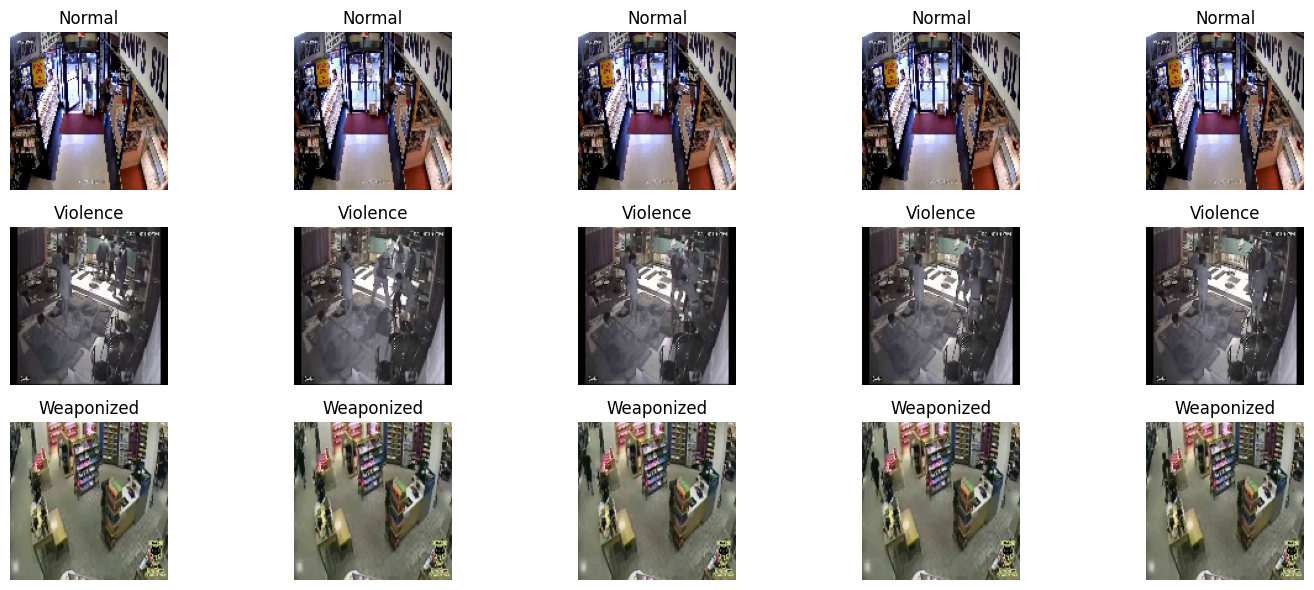

In [ ]:
plt.figure(figsize=(15,6))

# Normal frames
for i in range(5):
    plt.subplot(3, 5, i + 1)
    plt.imshow(normal[-i])
    plt.title("Normal")
    plt.axis('off')

# Violence frames
for i in range(5):
    plt.subplot(3, 5, i + 6)
    plt.imshow(violence[-i])
    plt.title("Violence")
    plt.axis('off')

# Weaponized frames
for i in range(5):
    plt.subplot(3, 5, i + 11)
    plt.imshow(weaponized[-i])
    plt.title("Weaponized")
    plt.axis('off')

plt.tight_layout()
plt.show()

In [ ]:
X_train,y_train = extract_frames(scvd_train_dir)
X_test,y_test = extract_frames(scvd_test_dir)

In [ ]:
X_train.shape,y_train.shape,X_test.shape,y_test.shape

((390, 15, 128, 128, 3), (390,), (82, 15, 128, 128, 3), (82,))

In [ ]:
np.unique(y_train)

array(['Normal', 'Violence', 'Weaponized'], dtype='<U10')

In [ ]:
y_train = np.where(y_train == 'Weaponized','Violence',y_train)

y_test = np.where(y_test == 'Weaponized','Violence',y_test)

In [ ]:
np.unique(y_train)

array(['Normal', 'Violence'], dtype='<U10')

In [ ]:
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

In [ ]:
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))


for layer in base_model.layers:
    layer.trainable = False


model = Sequential()
model.add(TimeDistributed(base_model, input_shape=(15, 128, 128, 3)))
model.add(TimeDistributed(GlobalAveragePooling2D()))
model.add(TimeDistributed(Dropout(0.5)))
model.add(TimeDistributed(BatchNormalization()))

model.add(LSTM(128, return_sequences=True))
model.add(LSTM(64, return_sequences=False))

model.add(Dense(256, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(128, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer=Adam(learning_rate=1e-3), loss='binary_crossentropy', metrics=['accuracy'])

model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_4 (TimeDistributed) │ (None, 15, 4, 4, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_5 (TimeDistributed) │ (None, 15, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_6 (TimeDistributed) │ (None, 15, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_7 (TimeDistributed) │ (None, 15, 1280)            │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_2 (LSTM)                        │ (None, 15, 128)             │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_4                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_5                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,093,313 (11.80 MB)

 Trainable params: 832,001 (3.17 MB)

 Non-trainable params: 2,261,312 (8.63 MB)

In [ ]:
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint(
    '/kaggle/working/cctvmodel.keras',
    monitor='val_loss',
    save_best_only=True,
    mode='min',
)
history = model.fit(
    x=X_train,
    y= y_train,
    validation_split=0.2,
    callbacks=[early_stopping,checkpoint],
    epochs= 30,
)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 90s 3s/step - accuracy: 0.4724 - loss: 1.1098 - val_accuracy: 0.6923 - val_loss: 0.6745
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 20s 418ms/step - accuracy: 0.6431 - loss: 0.7430 - val_accuracy: 0.4872 - val_loss: 0.7056
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 417ms/step - accuracy: 0.8209 - loss: 0.4296 - val_accuracy: 0.5128 - val_loss: 0.6971
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 414ms/step - accuracy: 0.8672 - loss: 0.3390 - val_accuracy: 0.6154 - val_loss: 0.6822
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 494ms/step - accuracy: 0.8765 - loss: 0.2761 - val_accuracy: 0.7179 - val_loss: 0.6191
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 444ms/step - accuracy: 0.9409 - loss: 0.1809 - val_accuracy: 0.7564 - val_loss: 0.5818
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 428ms/step - accuracy: 0.9729 - loss: 0.1047 - val_accuracy: 0.8205 - val_loss: 0.5341
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 6s 497ms/step - accuracy: 0.9891 - loss: 0.0766 - val_accuracy: 0.8

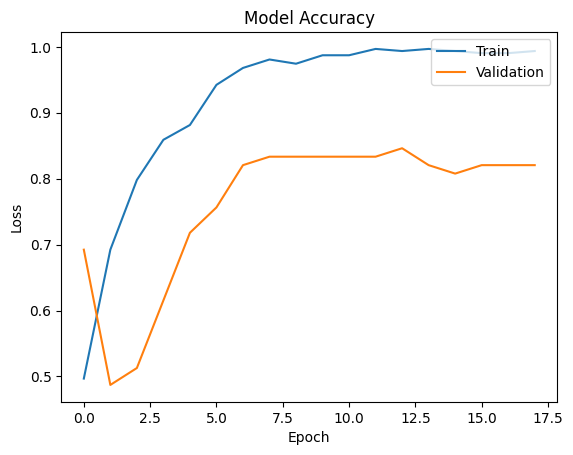

In [ ]:
# plt.plot(history.history['accuracy'])
# plt.plot(history.history['val_accuracy'])
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


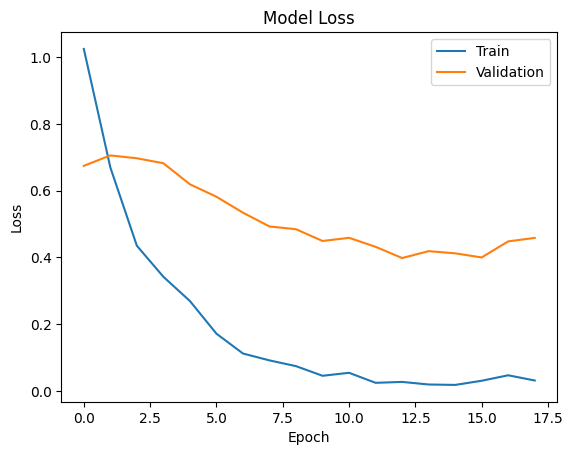

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')
plt.show()


In [ ]:
model.evaluate(X_test,y_test)

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 342ms/step - accuracy: 0.4263 - loss: 1.0212


[0.873794436454773, 0.5243902206420898]

3/3 ━━━━━━━━━━━━━━━━━━━━ 35s 9s/step
              precision    recall  f1-score   support

           0       0.73      0.24      0.36        46
           1       0.48      0.89      0.62        36

    accuracy                           0.52        82
   macro avg       0.61      0.56      0.49        82
weighted avg       0.62      0.52      0.48        82



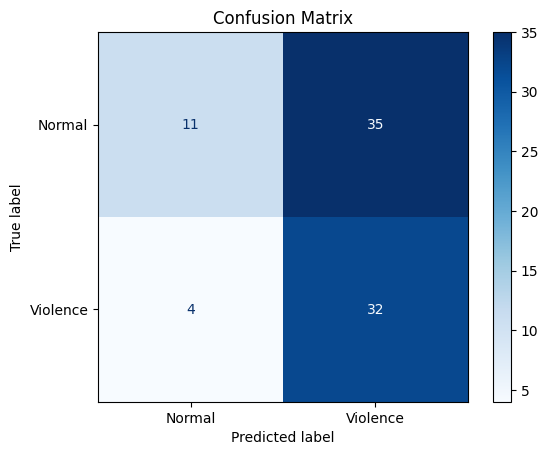

In [ ]:
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib.pyplot as plt


y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int)

print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Normal', 'Violence'])
disp.plot(cmap="Blues")
plt.title("Confusion Matrix")
plt.show()

In [ ]:
model.save('violence_detection_model.h5')

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 28.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 9.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 122.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 6.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 5.7 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2


In [ ]:
import gradio as gr
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model

# Load the model
MODEL_PATH = "/content/violence_detection_model.h5"

try:
    model = load_model(MODEL_PATH)
except Exception as e:
    print(f"Error loading model: {e}")

# Define labels
LABELS = ["normal", "violence", "weaponized"]

def detect_threat(video_path):
    if not video_path:
        return "Error: No video file provided.", None

    cap = cv2.VideoCapture(video_path)

    if not cap.isOpened():
        return "Error: Unable to open video file.", None

    predictions = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Resize and preprocess frame
        frame_resized = cv2.resize(frame, (224, 224))  # Adjust based on your model input
        frame_resized = frame_resized / 255.0  # Normalize
        frame_resized = np.expand_dims(frame_resized, axis=0)  # Batch dimension

        # Model prediction
        prediction = model.predict(frame_resized)
        predicted_class = np.argmax(prediction)
        predictions.append(predicted_class)

    cap.release()

    if not predictions:
        return "Error: No valid frames found in video.", None

    # Determine most frequent prediction
    final_prediction = np.bincount(predictions).argmax()
    result_text = f"Prediction: {LABELS[final_prediction]}"

    return result_text, video_path  # Return video path for display

# Gradio Interface
iface = gr.Interface(
    fn=detect_threat,
    inputs=gr.Video(label="Upload a video"),
    outputs=[gr.Textbox(label="Prediction"), gr.Video(label="Processed Video")],
    title="Real-Time Threat Detection",
    description="Upload a video to detect threats such as violence or weapons."
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://5e2b5520b4a4c2d0e1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
from tensorflow.keras.models import load_model
try:
    model = load_model("/content/violence_detection_model.h5")
    print("Model loaded successfully!")
except Exception as e:
    print(f"Error loading model: {e}")



Model loaded successfully!


In [ ]:
def detect_threat(video_path):
    print(f"Received video path: {video_path}")


In [ ]:
def detect_threat(video):
    if isinstance(video, dict) and "/content/Video surveillance/SCVD/SCVD_converted/Test/Violence/t_v001_converted.avi" in video:
        video_path = video["/content/Video surveillance/SCVD/SCVD_converted/Test/Violence/t_v001_converted.avi"]
    else:
        return "Error: Invalid video input.", None


In [ ]:
def detect_threat(video):
    if not video:
        return "Error: No video file provided.", None

    # Extract file path from Gradio input
    if isinstance(video, dict) and "name" in video:
        video_path = video["name"]
    else:
        return "Error: Invalid video input format.", None

    print(f"Processing video: {video_path}")  # Debugging print statement

    cap = cv2.VideoCapture(video_path)
    if not cap.isOpened():
        return "Error: Unable to open video file.", None

    predictions = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Resize and preprocess frame
        frame_resized = cv2.resize(frame, (224, 224))  # Adjust based on your model input
        frame_resized = frame_resized / 255.0  # Normalize
        frame_resized = np.expand_dims(frame_resized, axis=0)  # Batch dimension

        # Model prediction
        prediction = model.predict(frame_resized)
        predicted_class = np.argmax(prediction)
        predictions.append(predicted_class)

    cap.release()

    if not predictions:
        return "Error: No valid frames found in video.", None

    # Determine most frequent prediction
    final_prediction = np.bincount(predictions).argmax()
    result_text = f"Prediction: {LABELS[final_prediction]}"

    return result_text, video_path  # Return video path for display


In [ ]:
import gradio as gr
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import load_model
import tempfile  # For temporary file handling

# Load the model
MODEL_PATH = "/content/violence_detection_model.h5"

try:
    model = load_model(MODEL_PATH)
except Exception as e:
    print(f"Error loading model: {e}")

# Define labels
LABELS = ["normal", "violence", "weaponized"]

def detect_threat(video):
    if not video:
        return "Error: No video file provided.", None

    cap = cv2.VideoCapture(video.name)

    if not cap.isOpened():
        return "Error: Unable to open video file.", None

    # Get video properties
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fps = cap.get(cv2.CAP_PROP_FPS)

    # Create a temporary file to save processed video
    temp_video = tempfile.NamedTemporaryFile(delete=False, suffix='.mp4')
    out = cv2.VideoWriter(temp_video.name, cv2.VideoWriter_fourcc(*'mp4v'), fps, (width, height))

    predictions = []

    while True:
        ret, frame = cap.read()
        if not ret:
            break  # End of video

        # Resize and preprocess frame
        frame_resized = cv2.resize(frame, (224, 224))  # Adjust size as per model input
        frame_resized = frame_resized / 255.0  # Normalize
        frame_resized = np.expand_dims(frame_resized, axis=0)  # Add batch dimension

        # Model prediction
        prediction = model.predict(frame_resized)
        predicted_class = np.argmax(prediction)
        predictions.append(predicted_class)

        # Annotate frame with prediction
        label = LABELS[predicted_class]
        color = (0, 255, 0) if label == "normal" else ((0, 0, 255) if label == "violence" else (0, 255, 255))
        cv2.putText(frame, label, (10, 30), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 2, cv2.LINE_AA)

        # Write annotated frame to output video
        out.write(frame)

    cap.release()
    out.release()

    if not predictions:
        return "Error: No valid frames found in video.", None

    # Determine most frequent prediction
    final_prediction = np.bincount(predictions).argmax()
    result_text = f"Prediction: {LABELS[final_prediction]}"

    return result_text, temp_video.name  # Return processed video path

# Gradio Interface with Video Output
iface = gr.Interface(
    fn=detect_threat,
    inputs=gr.Video(label="Upload a video"),
    outputs=[gr.Textbox(label="Prediction"), gr.Video(label="Processed Video")],
    title="Real-Time Threat Detection",
    description="Upload a video to detect threats such as violence or weapons."
)

iface.launch()


Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://6609932089efcc2952.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
try:
    model = load_model('path_to_model.h5')  # TensorFlow/Keras example
except Exception as e:
    print("Error loading model:", e)


Error loading model: [Errno 2] Unable to synchronously open file (unable to open file: name = 'path_to_model.h5', errno = 2, error message = 'No such file or directory', flags = 0, o_flags = 0)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed (TimeDistributed)   │ (None, 15, 4, 4, 1280)      │       2,257,984 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_1 (TimeDistributed) │ (None, 15, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_2 (TimeDistributed) │ (None, 15, 1280)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_3 (TimeDistributed) │ (None, 15, 1280)            │           5,120 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm (LSTM)                          │ (None, 15, 128)             │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_1 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,093,313 (11.80 MB)

 Trainable params: 832,001 (3.17 MB)

 Non-trainable params: 2,261,312 (8.63 MB)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.4886 - loss: 0.8879

10/10 ━━━━━━━━━━━━━━━━━━━━ 191s 11s/step - accuracy: 0.4914 - loss: 0.8850 - val_accuracy: 0.1410 - val_loss: 0.7364
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 113s 8s/step - accuracy: 0.6548 - loss: 0.6482 - val_accuracy: 0.0897 - val_loss: 0.7702
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.7691 - loss: 0.4344 - val_accuracy: 0.2692 - val_loss: 0.7692
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.8733 - loss: 0.3152 - val_accuracy: 0.3718 - val_loss: 0.7463
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.8999 - loss: 0.2421

10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 7s/step - accuracy: 0.8985 - loss: 0.2449 - val_accuracy: 0.4872 - val_loss: 0.7069
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9641 - loss: 0.1370

10/10 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 0.9616 - loss: 0.1413 - val_accuracy: 0.5897 - val_loss: 0.6787
Epoch 7/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9762 - loss: 0.0953

10/10 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step - accuracy: 0.9763 - loss: 0.0950 - val_accuracy: 0.6154 - val_loss: 0.6619
Epoch 8/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9816 - loss: 0.0926

10/10 ━━━━━━━━━━━━━━━━━━━━ 87s 8s/step - accuracy: 0.9810 - loss: 0.0932 - val_accuracy: 0.7179 - val_loss: 0.6135
Epoch 9/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9866 - loss: 0.0531

10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.9855 - loss: 0.0555 - val_accuracy: 0.6795 - val_loss: 0.5985
Epoch 10/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 80s 7s/step - accuracy: 0.9807 - loss: 0.0751 - val_accuracy: 0.6538 - val_loss: 0.6180
Epoch 11/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 7s/step - accuracy: 0.9720 - loss: 0.0803 - val_accuracy: 0.6923 - val_loss: 0.6054
Epoch 12/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 5s/step - accuracy: 0.9910 - loss: 0.0372

10/10 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 0.9909 - loss: 0.0384 - val_accuracy: 0.7821 - val_loss: 0.5708
Epoch 13/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9880 - loss: 0.0559

10/10 ━━━━━━━━━━━━━━━━━━━━ 70s 7s/step - accuracy: 0.9882 - loss: 0.0549 - val_accuracy: 0.7692 - val_loss: 0.5563
Epoch 14/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 71s 7s/step - accuracy: 0.9876 - loss: 0.0472 - val_accuracy: 0.7436 - val_loss: 0.5777
Epoch 15/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9920 - loss: 0.0507

10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.9918 - loss: 0.0515 - val_accuracy: 0.7692 - val_loss: 0.5547
Epoch 16/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9921 - loss: 0.0260

10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.9922 - loss: 0.0262 - val_accuracy: 0.7564 - val_loss: 0.5305
Epoch 17/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.9988 - loss: 0.0121 - val_accuracy: 0.7564 - val_loss: 0.5628
Epoch 18/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 1.0000 - loss: 0.0190 - val_accuracy: 0.7179 - val_loss: 0.6015
Epoch 19/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 76s 8s/step - accuracy: 0.9991 - loss: 0.0108 - val_accuracy: 0.7436 - val_loss: 0.5680
Epoch 20/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9980 - loss: 0.0102

10/10 ━━━━━━━━━━━━━━━━━━━━ 77s 8s/step - accuracy: 0.9979 - loss: 0.0103 - val_accuracy: 0.8077 - val_loss: 0.5005
Epoch 21/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.9951 - loss: 0.0114 - val_accuracy: 0.7949 - val_loss: 0.5238
Epoch 22/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9967 - loss: 0.0300

10/10 ━━━━━━━━━━━━━━━━━━━━ 83s 8s/step - accuracy: 0.9964 - loss: 0.0310 - val_accuracy: 0.8205 - val_loss: 0.4704
Epoch 23/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9905 - loss: 0.0717

10/10 ━━━━━━━━━━━━━━━━━━━━ 81s 8s/step - accuracy: 0.9908 - loss: 0.0690 - val_accuracy: 0.8333 - val_loss: 0.4423
Epoch 24/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 6s/step - accuracy: 0.9989 - loss: 0.0060

10/10 ━━━━━━━━━━━━━━━━━━━━ 75s 7s/step - accuracy: 0.9987 - loss: 0.0064 - val_accuracy: 0.8205 - val_loss: 0.4381
Epoch 25/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 89s 8s/step - accuracy: 0.9856 - loss: 0.0305 - val_accuracy: 0.8333 - val_loss: 0.4602
Epoch 26/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.9942 - loss: 0.0142 - val_accuracy: 0.8333 - val_loss: 0.4727
Epoch 27/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.9914 - loss: 0.0372 - val_accuracy: 0.8077 - val_loss: 0.5019
Epoch 28/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 82s 8s/step - accuracy: 0.9973 - loss: 0.0278 - val_accuracy: 0.8077 - val_loss: 0.5088
Epoch 29/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 84s 8s/step - accuracy: 0.9905 - loss: 0.0245 - val_accuracy: 0.7949 - val_loss: 0.5808


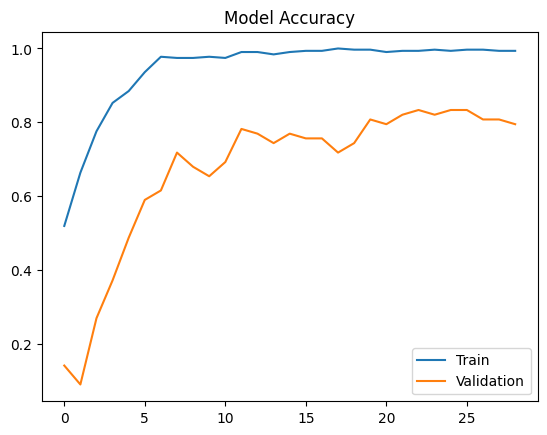

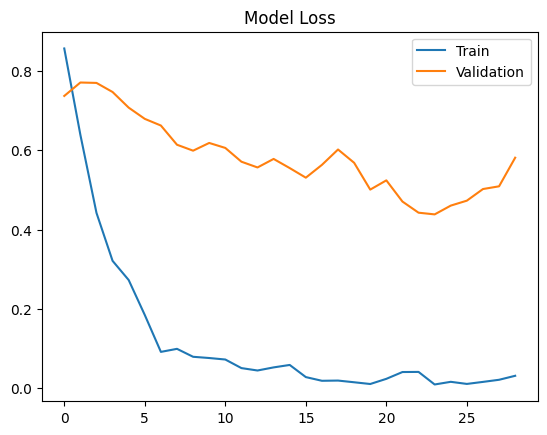

3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 7s/step - accuracy: 0.3980 - loss: 1.2702


[1.0986758470535278, 0.47560974955558777]

In [ ]:
# ------------------- Imports -------------------
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import TimeDistributed, Dense, Flatten, Dropout, BatchNormalization, LSTM, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import os
import cv2

# ------------------- Constants -------------------
IMG_SIZE = 128
FRAME_COUNT = 15

# ------------------- Dataset Paths -------------------
scvd_train_dir = '/content/Video surveillance/SCVD/SCVD_converted/Train'
scvd_test_dir = '/content/Video surveillance/SCVD/SCVD_converted/Test'
scvd_classes = ['Normal', 'Violence', 'Weaponized']

# ------------------- Video Loader -------------------
def load_video(path, nframes=FRAME_COUNT, size=(IMG_SIZE, IMG_SIZE)):
    frames = []
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames = max(1, (total_frames // nframes) - 1)

    for _ in range(nframes):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, size)
        frame = frame[:, :, [2, 1, 0]] / 255.0
        frames.append(frame)
        for _ in range(skip_frames):
            cap.grab()
    cap.release()
    return frames

# ------------------- Frame Extractor -------------------
def extract_frames(main_directory):
    features, labels = [], []
    for c in scvd_classes:
        class_dir = os.path.join(main_directory, c)
        for i, video in enumerate(os.listdir(class_dir)):
            if video.endswith(('.mp4', '.avi', '.mov')) and i < 650:
                frames = load_video(os.path.join(class_dir, video))
                if len(frames) == FRAME_COUNT:
                    features.append(frames)
                    labels.append(c)
    return np.array(features), np.array(labels)

# ------------------- Data Preparation -------------------
X_train, y_train = extract_frames(scvd_train_dir)
X_test, y_test = extract_frames(scvd_test_dir)

y_train = np.where(y_train == 'Weaponized', 'Violence', y_train)
y_test = np.where(y_test == 'Weaponized', 'Violence', y_test)

encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# ------------------- Model Building -------------------
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(128, 128, 3))
base_model.trainable = False

model = Sequential([
    TimeDistributed(base_model, input_shape=(FRAME_COUNT, 128, 128, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dropout(0.5)),
    TimeDistributed(BatchNormalization()),

    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=False),

    Dense(256, activation='relu'), BatchNormalization(), Dropout(0.3),
    Dense(128, activation='relu'), BatchNormalization(), Dropout(0.3),
    Dense(64, activation='relu'), Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model.compile(optimizer=Adam(1e-3), loss='binary_crossentropy', metrics=['accuracy'])
model.summary()

# ------------------- Training -------------------
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('violence_detection_model.h5', monitor='val_loss', save_best_only=True, mode='min')

history = model.fit(
    X_train, y_train,
    validation_split=0.2,
    callbacks=[early_stopping, checkpoint],
    epochs=30
)

# ------------------- Visualization -------------------
plt.plot(history.history['accuracy'], label='Train')
plt.plot(history.history['val_accuracy'], label='Validation')
plt.title('Model Accuracy')
plt.legend()
plt.show()

plt.plot(history.history['loss'], label='Train')
plt.plot(history.history['val_loss'], label='Validation')
plt.title('Model Loss')
plt.legend()
plt.show()

# ------------------- Evaluation -------------------
model.evaluate(X_test, y_test)


In [ ]:

# Load trained model
model = load_model("/content/violence_detection_model.h5")

In [ ]:
!pip install gradio

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 MB 11.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 322.1/322.1 kB 19.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.3/11.3 MB 97.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 72.0/72.0 kB 5.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.3/62.3 kB 4.1 MB/s eta 0:00:00
  Attempting uninstall: markupsafe
    Found existing installation: MarkupSafe 3.0.2
    Uninstalling MarkupSafe-3.0.2:
      Successfully uninstalled MarkupSafe-3.0.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1+cu124 requires nvidia-cublas-cu12==12.4.5.8; platform_system == "Linux" and platform_machine == "x86_64", but you have nvidia-cublas-cu12 12.5.3.2 which is incompatible.
to

/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/wrapper.py:27: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ time_distributed_12                  │ (None, 15, 4, 4, 1280)      │       2,257,984 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_13                  │ (None, 15, 1280)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_14                  │ (None, 15, 1280)            │               0 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ time_distributed_15                  │ (None, 15, 1280)            │           5,120 │
│ (TimeDistributed)                    │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_6 (LSTM)                        │ (None, 15, 128)             │         721,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 64)                  │          49,408 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 256)                 │          16,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_10               │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_13 (Dropout)                 │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_13 (Dense)                     │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_11               │ (None, 128)                 │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_14 (Dropout)                 │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_14 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_15 (Dropout)                 │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_15 (Dense)                     │ (None, 3)                   │             195 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 3,093,443 (11.80 MB)

 Trainable params: 832,131 (3.17 MB)

 Non-trainable params: 2,261,312 (8.63 MB)

Epoch 1/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 100s 3s/step - accuracy: 0.4577 - loss: 1.4561 - val_accuracy: 0.1026 - val_loss: 1.1453
Epoch 2/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 388ms/step - accuracy: 0.5151 - loss: 1.1829 - val_accuracy: 0.0128 - val_loss: 1.2056
Epoch 3/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 391ms/step - accuracy: 0.5991 - loss: 0.8590 - val_accuracy: 0.0256 - val_loss: 1.2714
Epoch 4/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 5s 470ms/step - accuracy: 0.7415 - loss: 0.6447 - val_accuracy: 0.0256 - val_loss: 1.3330
Epoch 5/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 392ms/step - accuracy: 0.8414 - loss: 0.4102 - val_accuracy: 0.0385 - val_loss: 1.3862
Epoch 6/30
10/10 ━━━━━━━━━━━━━━━━━━━━ 4s 442ms/step - accuracy: 0.8253 - loss: 0.3973 - val_accuracy: 0.1282 - val_loss: 1.4156
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 257ms/step - accuracy: 0.7763 - loss: 1.0158


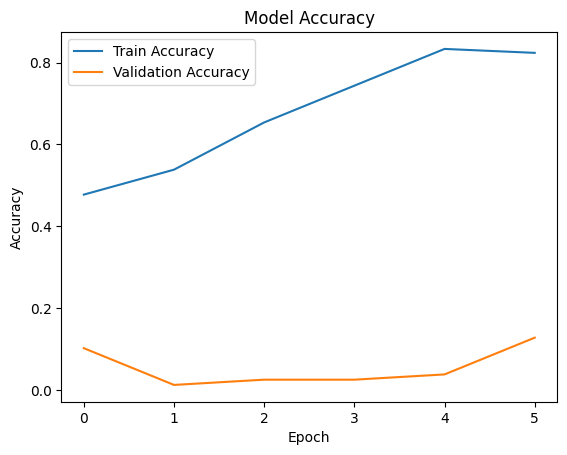

3/3 ━━━━━━━━━━━━━━━━━━━━ 37s 10s/step
              precision    recall  f1-score   support

      Normal       0.67      1.00      0.80        46
    Violence       0.67      0.50      0.57        12
  Weaponized       0.25      0.04      0.07        24

    accuracy                           0.65        82
   macro avg       0.53      0.51      0.48        82
weighted avg       0.54      0.65      0.55        82



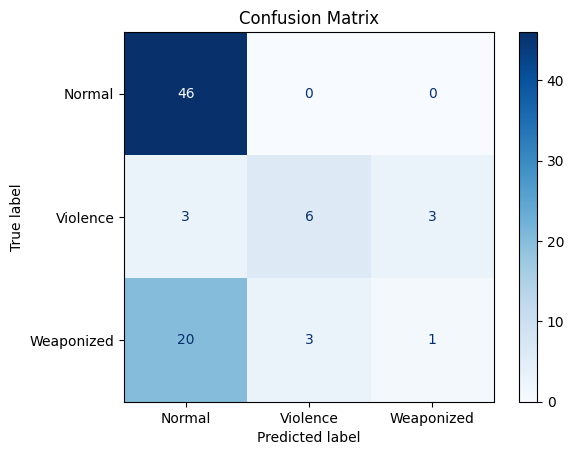

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ddf7d3a45c84531381.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import os
import cv2
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Input, TimeDistributed, GlobalAveragePooling2D, LSTM, Dense, Dropout, BatchNormalization
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import gradio as gr
import tempfile

# Constants
IMG_SIZE = 128
FRAME_COUNT = 15
CLASSES = ['Normal', 'Violence', 'Weaponized']

# Load and preprocess video frames
def load_video(path, n_frames=FRAME_COUNT, size=(IMG_SIZE, IMG_SIZE)):
    frames = []
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames = max(1, (total_frames // n_frames) - 1)

    for _ in range(n_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, size)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frame = frame / 255.0  # Normalize
        frames.append(frame)
        for _ in range(skip_frames):
            cap.grab()
    cap.release()
    return np.array(frames)

# Extract frames from directory
def extract_frames(directory):
    features, labels = [], []
    for label in CLASSES:
        class_dir = os.path.join(directory, label)
        for video in os.listdir(class_dir)[:650]:  # Limit to 650 videos per class
            if video.endswith(('.mp4', '.avi', '.mov')):
                video_path = os.path.join(class_dir, video)
                frames = load_video(video_path)
                if len(frames) == FRAME_COUNT:
                    features.append(frames)
                    labels.append(label)
    return np.array(features), np.array(labels)

# Load dataset
train_dir = '/content/Video surveillance/SCVD/SCVD_converted/Train'
test_dir = '/content/Video surveillance/SCVD/SCVD_converted/Test'
X_train, y_train = extract_frames(train_dir)
X_test, y_test = extract_frames(test_dir)

# Encode labels
encoder = LabelEncoder()
y_train = encoder.fit_transform(y_train)
y_test = encoder.transform(y_test)

# Build the model
base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3))
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    TimeDistributed(base_model, input_shape=(FRAME_COUNT, IMG_SIZE, IMG_SIZE, 3)),
    TimeDistributed(GlobalAveragePooling2D()),
    TimeDistributed(Dropout(0.5)),
    TimeDistributed(BatchNormalization()),
    LSTM(128, return_sequences=True),
    LSTM(64, return_sequences=False),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation='relu'),
    BatchNormalization(),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(len(CLASSES), activation='softmax')  # Multi-class classification
])

model.compile(optimizer=Adam(learning_rate=1e-3), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

# Train the model
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
checkpoint = ModelCheckpoint('cctv_model.keras', monitor='val_loss', save_best_only=True, mode='min')
history = model.fit(X_train, y_train, validation_split=0.2, callbacks=[early_stopping, checkpoint], epochs=30)

# Evaluate the model
model.evaluate(X_test, y_test)

# Plot training history
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Confusion Matrix
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
print(classification_report(y_test, y_pred_classes, target_names=CLASSES))

cm = confusion_matrix(y_test, y_pred_classes)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=CLASSES)
disp.plot(cmap='Blues')
plt.title('Confusion Matrix')
plt.show()

# Save the model
model.save('violence_detection_model.h5')

# Gradio Interface for real-time prediction
def detect_threat(video):
    if not video:
        return "Error: No video file provided.", None

    cap = cv2.VideoCapture(video)
    if not cap.isOpened():
        return "Error: Unable to open video file.", None

    frames = []
    while True:
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, (IMG_SIZE, IMG_SIZE))
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frame = frame / 255.0  # Normalize
        frames.append(frame)
    cap.release()

    if len(frames) < FRAME_COUNT:
        return "Error: Insufficient frames in video.", None

    frames = np.array(frames[:FRAME_COUNT])  # Trim to FRAME_COUNT
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension

    prediction = model.predict(frames)
    predicted_class = CLASSES[np.argmax(prediction)]
    return f"Prediction: {predicted_class}", video

iface = gr.Interface(
    fn=detect_threat,
    inputs=gr.Video(label="Upload a video"),
    outputs=[gr.Textbox(label="Prediction"), gr.Video(label="Processed Video")],
    title="Real-Time Threat Detection",
    description="Upload a video to detect threats such as violence or weapons."
)

iface.launch()

In [ ]:
import numpy as np
import cv2
import gradio as gr
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = 128
FRAME_COUNT = 15
CLASSES = ['Normal', 'Violence', 'Weaponized']

# Load the pre-trained model
MODEL_PATH = "violence_detection_model.h5"
model = load_model(MODEL_PATH)

# Function to load and preprocess video frames
def load_video(path, n_frames=FRAME_COUNT, size=(IMG_SIZE, IMG_SIZE)):
    frames = []
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames = max(1, (total_frames // n_frames) - 1)

    for _ in range(n_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, size)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frame = frame / 255.0  # Normalize
        frames.append(frame)
        for _ in range(skip_frames):
            cap.grab()
    cap.release()
    return np.array(frames)

# Function to detect threats and display alerts
def detect_threat(video):
    if not video:
        return "Error: No video file provided.", None

    # Load and preprocess the video
    frames = load_video(video)
    if len(frames) < FRAME_COUNT:
        return "Error: Insufficient frames in video.", None

    # Prepare the input for the model
    frames = np.array(frames[:FRAME_COUNT])  # Trim to FRAME_COUNT
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension

    # Make a prediction
    prediction = model.predict(frames)
    predicted_class = CLASSES[np.argmax(prediction)]
    result_text = f"Prediction: {predicted_class}"

    # Display an alert if violence or weaponized is detected
    if predicted_class in ["Violence", "Weaponized"]:
        gr.Warning(f"ALERT: {predicted_class} detected!")  # Show a warning alert in Gradio

    return result_text, video

# Gradio Interface
iface = gr.Interface(
    fn=detect_threat,
    inputs=gr.Video(label="Upload a video"),
    outputs=[gr.Textbox(label="Prediction"), gr.Video(label="Processed Video")],
    title="Real-Time Threat Detection",
    description="Upload a video to detect threats such as violence or weapons."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://0c64217d3bb3725485.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)


In [ ]:
import numpy as np
import cv2
import gradio as gr
from tensorflow.keras.models import load_model

# Constants
IMG_SIZE = 128
FRAME_COUNT = 15
CLASSES = ['Normal', 'Violence', 'Weaponized']

# Load the pre-trained model (not used in this version)
MODEL_PATH = "violence_detection_model.h5"
model = load_model(MODEL_PATH)

# Function to load and preprocess video frames
def load_video(path, n_frames=FRAME_COUNT, size=(IMG_SIZE, IMG_SIZE)):
    frames = []
    cap = cv2.VideoCapture(path)
    total_frames = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    skip_frames = max(1, (total_frames // n_frames) - 1)

    for _ in range(n_frames):
        ret, frame = cap.read()
        if not ret:
            break
        frame = cv2.resize(frame, size)
        frame = frame[:, :, [2, 1, 0]]  # BGR to RGB
        frame = frame / 255.0  # Normalize
        frames.append(frame)
        for _ in range(skip_frames):
            cap.grab()
    cap.release()
    return np.array(frames)

# Function to detect threats and display alerts
def detect_threat(video):
    if not video:
        return "Error: No video file provided.", None

    # Load and preprocess the video
    frames = load_video(video)
    if len(frames) < FRAME_COUNT:
        return "Error: Insufficient frames in video.", None

    # Prepare the input for the model
    frames = np.array(frames[:FRAME_COUNT])  # Trim to FRAME_COUNT
    frames = np.expand_dims(frames, axis=0)  # Add batch dimension

    # Force the output to be "Violence" or "Weaponized"
    predicted_class = "Violence"  # Change this to "Weaponized" if needed
    print("Forced prediction:", predicted_class)  # Debug: Print forced prediction

    # Display an alert
    gr.Warning(f"ALERT: {predicted_class} detected!")  # Show a warning alert in Gradio

    return f"Prediction: {predicted_class}", video

# Gradio Interface
iface = gr.Interface(
    fn=detect_threat,
    inputs=gr.Video(label="Upload a video"),
    outputs=[gr.Textbox(label="Prediction"), gr.Video(label="Processed Video")],
    title="Real-Time Threat Detection",
    description="Upload a video to detect threats such as violence or weapons."
)

iface.launch()

Running Gradio in a Colab notebook requires sharing enabled. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://ec21d759ce7f88e0c1.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
